# Sentiment Analysis using TextBlob

In [82]:
!pip install textblob
!pip install tweepy

In [79]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
from tweepy import API
from tweepy import Cursor
from textblob import TextBlob
import re
%matplotlib inline

In [81]:
import twitterapi

class TwitterClient():
    
    def __init__(self,twitter_user=None):
        self.auth = TwitterAuthenticator().authenticate_twitter_app()
        self.twitter_client = API(self.auth)
        self.twitter_user = twitter_user
    
    def get_twitter_client_api(self):
        return self.twitter_client
    
    
    def get_user_timeline_tweets(self,num_tweets):
        tweets = []
        for tweet in Cursor(self.twitter_client.user_timeline, id = self.twitter_user).items(num_tweets):
            tweets.append(tweet)
        return tweets 
    
    def get_friend_list(self, num_friends):
        friend_list = []
        for friend in Cursor(self.twitter_client.friends,id = self.twitter_user).items(num_friends):
            friend_list.append(friend)
        return friend_list
    
    def get_home_timeline_tweets(self,num_tweets):
        home_timeline_tweets = []
        for tweet in Cursor(self.twitter_client.home_timeline,id = self.twitter_user).items(num_tweets):
            home_timeline_tweets.append(tweet)
        return home_timeline_tweets    
class TwitterAuthenticator():
    
    def authenticate_twitter_app(self):
        auth = OAuthHandler(twitterapi.CONSUMER_KEY, twitterapi.CONSUMER_SECRET)
        auth.set_access_token(twitterapi.ACCESS_TOKEN, twitterapi.ACCESS_TOKEN_SECRET)
        return auth
class TwitterStreamers():
    
    def __init__(self):
        self.twitter_authenticator = TwitterAuthenticator()
    
    def stream_tweets(self, fetched_tweets_filename, hashtag_list):
        listner = TwitterListner(fetched_tweets_filename)
        auth = self.twitter_authenticator.authenticate_twitter_app()
    
        stream = Stream(auth, listner)
        stream.filter(track = hashtag_list)

class TwitterListner(StreamListener):
    
    def __init__(self, fetched_tweets_filename):
        self.fetched_tweets_filename = fetched_tweets_filename
        
    def on_data(self, data):
        try:
            print(data)
            with open(self.fetched_tweets_filename, 'a') as tf:
                tf.write(data)
            return True
        except BaseException as e:
            print ("Error on_data: %s" %str(e))
        return True
    
    def on_error(self, status):
        if status == 420:
            return False
        print(status)
class TweetAnalyzer():
    
    def clean_tweet(self, tweet):
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split())
    
    def analyze_sentiment(self,tweet):
        analysis = TextBlob(self.clean_tweet(tweet))
        if analysis.sentiment.polarity > 0:
            return 1
        elif analysis.sentiment.polarity == 0:
            return 0
        else:
            return -1
    def tweets_to_df(self, tweets):
        df = pd.DataFrame(data=[tweet.text for tweet in tweets],columns = ['tweets'])
        df['id'] = np.array([tweet.id for tweet in tweets])
        df['len'] = np.array([len(tweet.text) for tweet in tweets])
        df['date'] = np.array([tweet.created_at for tweet in tweets])
        df['source'] = np.array([tweet.source for tweet in tweets])
        df['likes'] = np.array([tweet.favorite_count for tweet in tweets])
        df['retweets'] = np.array([tweet.retweet_count for tweet in tweets])
        return df
if __name__ == '__main__':
    
    twitter_client = TwitterClient()
    api = twitter_client.get_twitter_client_api()
    tweet_analyzer = TweetAnalyzer()
    
    #df = tweet_analyzer.tweets_to_df(tweets)
    tweets = api.user_timeline(screen_name = 'realDonaldTrump', count = 200)
    df = tweet_analyzer.tweets_to_df(tweets)
    df['sentiment'] = np.array([tweet_analyzer.analyze_sentiment(tweet) for tweet in df['tweets']])
    print (df)
    #print(dir(tweets[0]))
#     hashtag_list = ["donald trump"]
#     fetched_tweets_filename = "tweets.json"
#     twitter_client= TwitterClient('pycon')
#     print(twitter_client.get_user_timeline_tweets(5))
# #    twitter_streamer = TwitterStreamers()
# #    twitter_streamer.stream_tweets(fetched_tweets_filename, hashtag_list)

                                                tweets                   id  \
0    ....have a Radical Left nonbeliever, who wants...  1207997319821615105   
1    A far left magazine, or very “progressive,” as...  1207997316424187905   
2    RT @realDonaldTrump: SUCH ATROCIOUS LIES BY TH...  1207986340010299392   
3    RT @Cernovich: Trump is still your President a...  1207986289959723008   
4         RT @realDonaldTrump: https://t.co/DutxclyZw9  1207986133025599488   
5    RT @thehill: Pierce Brosnan praises Trump: "Wh...  1207985889592430592   
6    RT @TheRyanNYC1: @realDonaldTrump @greggutfeld...  1207985288557019136   
7    RT @MaryEileenGard3: @MomJar1 @realDonaldTrump...  1207984963364241409   
8    RT @MomJar1: @realDonaldTrump @greggutfeld @Fo...  1207984903020785664   
9    RT @Jim_Jordan: Yesterday the Democrats impeac...  1207982316817129479   
10   RT @Jim_Jordan: Dems called it an emergency. T...  1207982160222851072   
11    Thank you Bill. So true! https://t.co/BaMNE4TX

In [67]:
#Average Length of tweets
print (np.mean(df['len']))

120.16


In [68]:
#Most liked tweet
print (np.max(df['likes']))

427330


In [69]:
#Most retweeted tweet
print (np.max(df['retweets']))

115702


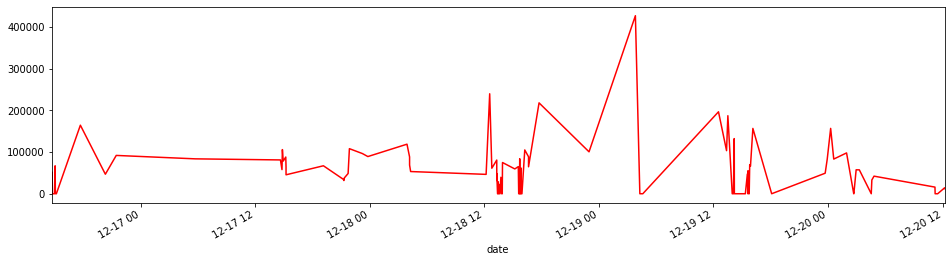

In [73]:
#time Series for likes
time_likes = pd.Series(data=df['likes'].values,index = df['date'])
time_likes.plot(figsize=(16,4), color = 'r')
plt.show()

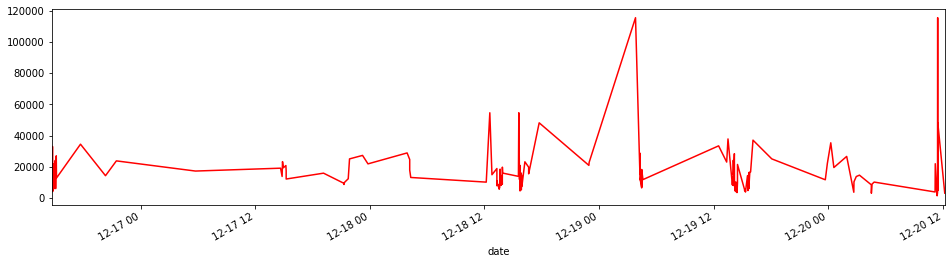

In [74]:
#time Series for retweets
time_retweets = pd.Series(data=df['retweets'].values,index = df['date'])
time_retweets.plot(figsize=(16,4), color = 'r')
plt.show()

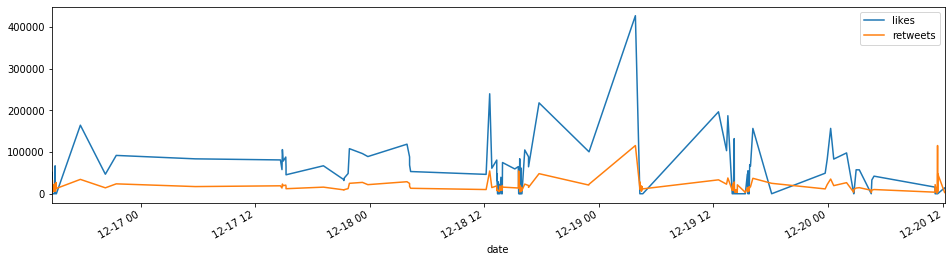

In [75]:
#time Series for likes
time_likes = pd.Series(data=df['likes'].values,index = df['date'])
time_likes.plot(figsize=(16,4), label = 'likes', legend = True)
time_retweets = pd.Series(data=df['retweets'].values,index = df['date'])
time_retweets.plot(figsize=(16,4), label = 'retweets', legend = True)
plt.show()